In [2]:
#!pip install opencv-python
#!pip install keras_vis
#!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.8/643.8 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import mlflow

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2


2025-01-31 12:40:24.034055: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 12:40:24.826340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738327225.139659  135364 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738327225.230071  135364 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 12:40:26.117066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import mlflow.keras
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# 1️⃣ Load Model from MLflow
def load_model_from_mlflow(server_uri, model_path):
    """
    Load a model from an MLflow tracking server.
    """
    print(f"Loading model from {server_uri} at {model_path}...")
    keras_model = mlflow.keras.load_model(model_path)

    # Print model summary
    keras_model.summary()

    return keras_model

# 2️⃣ Extract Base Model (if needed)
def initialize_submodel(keras_model, submodel_index=1):
    """
    Initialize the sub-model if the main model is wrapped in multiple layers.
    """
    base_model = keras_model.layers[submodel_index]  # Extract the sub-model

    # Ensure the model is built by passing a dummy input
    input_shape = base_model.input_shape[1:]  # Remove batch dimension
    dummy_input = np.random.random((1, *input_shape)).astype(np.float32)
    _ = base_model(dummy_input)  # Call model to initialize

    print(f"Sub-model {base_model.name} initialized successfully.")

    return base_model

# 3️⃣ Compute Grad-CAM Heatmap
def get_gradcam_heatmap(keras_model, img_array, layer_name):
    """
    Generate Grad-CAM heatmap for an image using a specific model layer.
    """
    # Ensure input shape is correct
    img_array = np.expand_dims(img_array, axis=0) if img_array.ndim == 3 else img_array

    # Extract the convolutional layer and model output
    conv_layer = keras_model.get_layer(layer_name).output  # (None, 2, 2, 2048)
    model_output_layer = keras_model.output  # (None, 7)

    # Create a new model that outputs both feature maps and predictions
    grad_model = Model(inputs=keras_model.input, outputs=[conv_layer, model_output_layer])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        # Select the class with highest probability
        pred_index = tf.argmax(predictions[0])
        loss = tf.gather(predictions[0], pred_index)  # Ensures correct shape

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Global Average Pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the gradients with the feature maps
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)  # Normalize between 0-1

    return heatmap.numpy()




# 4️⃣ Apply Grad-CAM to Image
def apply_gradcam(image_path, keras_model, layer_name):
    """
    Applies Grad-CAM on an image and overlays the heatmap on the original image.
    """
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error: Unable to read image at {image_path}. Check the file path.")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (128, 128))  # Resize to match model input
    img_array = img.astype(np.float32) / 255.0  # Normalize pixel values

    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 128, 128, 3)

    # Debugging print
    print("Final img_array shape:", img_array.shape)  # Should be (1, 128, 128, 3)

    # Generate Grad-CAM heatmap
    heatmap = get_gradcam_heatmap(keras_model, img_array, layer_name)

    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)  # Convert to uint8 (0-255)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap

    # Superimpose heatmap on original image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Save and display result
    cv2.imwrite("gradcam_image.jpg", superimposed_img)
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()


In [8]:
# Step 1: Load the model from MLflow
mlops_server_uri = "https://david-rem-jedha-final-project-mlops.hf.space"
model_path = "models:/lung_7_classes/2"
#keras_model = load_model_from_mlflow(mlops_server_uri, model_path)
mlflow.set_tracking_uri(mlops_server_uri)
keras_model = mlflow.keras.load_model(model_path)

Sub-model InceptionV3 initialized successfully.
Using last convolutional layer: mixed7
Final img_array shape: (1, 128, 128, 3)


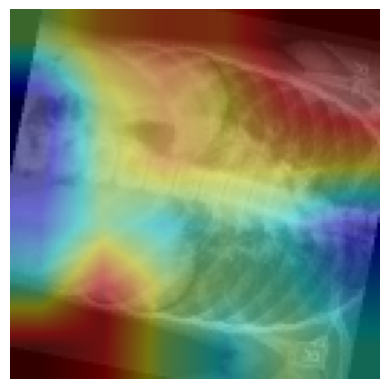

In [28]:
# Step 2: Extract & Initialize Base Model
base_model = initialize_submodel(keras_model, submodel_index=1)  # Adjust index if needed

# Step 3: Get Last Conv Layer Name
#last_conv_layer_name = base_model.layers[-1].name
last_conv_layer_name = "mixed7" # conv2d_75, 71, 74, 70
print(f"Using last convolutional layer: {last_conv_layer_name}")

# Step 4: Apply Grad-CAM on an Image
apply_gradcam("image_0520.jpg", base_model, last_conv_layer_name)

In [6]:
for layer in keras_model.layers:
    print(layer.name)
    
print('\n')

for layer in keras_model.layers[1].layers:
    print(layer.name)

print('\n')

last_conv_layer_name = keras_model.layers[1].layers[-1].name
print(last_conv_layer_name)

conv2d_94
InceptionV3
flatten
dense


input_layer
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
b